# Noise and Filters
## Noise in Images
* random noise
* periodic noise

### Gaussian Noise
white noise generally used when no prior knowledge about noise is available
$$
N(p; 0, \sigma_n^2) = \frac{1}{\sqrt{2 \pi \sigma_n^2}} \exp \left( - \frac{p^2}{2 \sigma_n^2} \right)
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# prepare a sample image
orig_img = np.zeros((128, 128, 1))
for i in range(8):
    for j in range(8):
        orig_img[i*16:(i+1)*16, j*16:(j+1)*16] = abs(i + j) / 16.

In [3]:
# add gaussian noise with s.d. of 0.05
gaussian_noise = np.random.normal(size=orig_img.shape) * 0.01
grid_gaussian = np.clip(orig_img + gaussian_noise, 0., 1.)

Text(0.5, 1.0, 'gaussian')

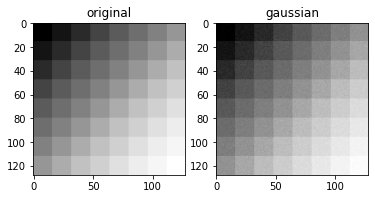

In [4]:
# show results
plt.subplot(1, 2, 1)
plt.imshow(orig_img, cmap="Greys_r")
plt.title("original")
plt.subplot(1, 2, 2)
plt.imshow(grid_gaussian, cmap="Greys_r")
plt.title("gaussian")

### Inpulsive Noise
Noise typically caused by malfunctioning element, signal transfer, A/D conversion, etc.

e.g., salt-and-pepper noise
$$
I_{obs} (i, j) =
  \begin{cases}
    I(i, j) & \alpha < l \\
    (1 - \beta) v_{\mathrm{min}} + \beta v_{\mathrm{max}} & \alpha \geq l
  \end{cases} \\
\mathrm{where} \quad \alpha, \beta \sim U(0, 1)
$$

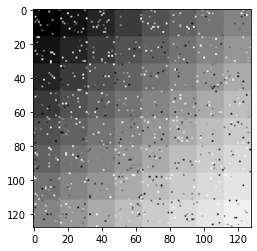

In [5]:
# add impulsive noise
img_size = orig_img.shape
impulsive_noise = np.where(np.random.uniform(size=img_size) < 0.95, orig_img, np.random.uniform(size=img_size))
grid_impulsive = np.clip(impulsive_noise, 0., 1.)
plt.imshow(grid_impulsive, cmap="Greys_r")

## Linear Filter
convolution of a image $I$ and a linear filter $A$
$$
I_A(i, j) = I * A = \sum_{k=-\frac{m}{2}}^{\frac{m}{2}} \sum_{l=-\frac{m}{2}}^{\frac{m}{2}} A(k, l) I(i - k, j - l)
$$

In [6]:
def pad(image, h_size, w_size):
    assert not (h_size == 0 and w_size == 0)
    extended_shape = list(image.shape)
    extended_shape[0] = extended_shape[0] + 2 * h_size
    extended_shape[1] = extended_shape[1] + 2 * w_size
    extended = np.empty(extended_shape)
    
    # center
    if h_size == 0:
        extended[:, w_size:-w_size, :] = image
    elif w_size == 0:
        extended[h_size:-h_size, :, :] = image
    else:
        extended[h_size:-h_size, w_size:-w_size, :] = image
    # edges and corners
    for i in range(h_size):
        extended[       i, :, :] = extended[       h_size, :, :]
        extended[-(i + 1), :, :] = extended[-(h_size + 1), :, :]
    for j in range(w_size):
        extended[:,        j, :] = extended[:,        w_size, :]
        extended[:, -(j + 1), :] = extended[:, -(w_size + 1), :]
    return extended        

In [7]:
def conv2d(image, kernel):
    # kernel size should be an odd number
    assert kernel.shape[0] % 2 == 1 and kernel.shape[1] % 2 == 1
    # here, assume a square kernel
    assert kernel.shape[0] == kernel.shape[1]
    
    m = kernel.shape[0]
    mdiv2 = m // 2
    h, w, c = image.shape
    
    # extend the image to apply a kernel to the edge of it
    extended = pad(image, mdiv2, mdiv2)
    
    # convolution
    # Most naive implementation: time complexity of O(HWCM^2)
    result = np.zeros_like(image)
    for i in range(h):
        for j in range(w):
            for k in range(-mdiv2, mdiv2 + 1):
                for l in range(-mdiv2, mdiv2 + 1):
                    for ch in range(c):
                        result[i, j, ch] += extended[i - k + mdiv2, j - l + mdiv2, ch] * kernel[mdiv2 + k, mdiv2 + l]
    return result        

### Moving Mean Filter
The simplest linearfilter. Behave as a low-pass filter.


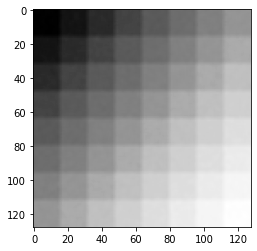

In [8]:
# apply moving mean filter to the image including gaussian noise
mmf_kernel = np.ones((3, 3), dtype=np.float32) / 9.
filtered = conv2d(grid_gaussian, mmf_kernel)
plt.imshow(filtered, cmap="Greys_r")

MMF reduces the noise but blurs the edges.

### Gaussian Filter
Use Gaussian as a kernel
e.g., Gaussian kernel with the size of 3x3:
$$
\begin{bmatrix}
1/16 & 2/16 & 1/16 \\
2/16 & 4/16 & 2/16 \\
1/16 & 2/16 & 1/16
\end{bmatrix}
$$

In [9]:
def create_gaussian_kernel(size):
    assert size % 2 == 1
    sdiv2 = size // 2
    
    # standard deviation
    sd = size / 4.
    
    # create gaussian kernel
    kernel = np.empty((size, size))
    i_mesh = np.arange(-sdiv2, sdiv2 + 1).reshape((1, -1))
    i_mseh = np.repeat(i_mesh, size, axis=0).astype(np.float64)
    j_mesh = np.arange(-sdiv2, sdiv2 + 1).reshape((-1, 1))
    j_mesh = np.repeat(j_mesh, size, axis=1).astype(np.float64)
    # compute kernel
    kernel = np.exp(-0.5 * np.square(i_mesh / sd)) * np.exp(-0.5 * np.square(j_mesh / sd)) * 0.5 / (np.pi * sd * sd)
    # normalize
    kernel = kernel / np.sum(kernel)
    
    return kernel

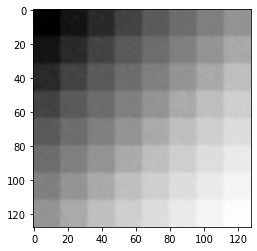

In [10]:
# apply Gaussian filter
gaussian_kernel = create_gaussian_kernel(3)
filtered = conv2d(grid_gaussian, gaussian_kernel)
plt.imshow(filtered, cmap="Greys_r")

The Gaussian filter is different from the MMF in that it has no secondary ingredient in the spectrum

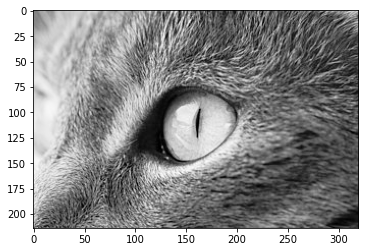

In [11]:
# comparison btw gaussian filter and moving mean filter
from PIL import Image
img = Image.open("./img/320px-Grayscale_Cat.jpg") # https://commons.wikimedia.org/wiki/File:Grayscale_Cat.jpg
# convert to gray scale
img = img.convert("L")
img = np.asarray(img).astype(np.float64) / 255.
img = np.reshape(img, (img.shape[0], img.shape[1], 1))
plt.imshow(img, cmap="Greys_r")

In [12]:
# apply filters
gaussian_kernel = create_gaussian_kernel(13)
mmf_kernel = np.ones((13, 13)) / (13. * 13.)
g_img = conv2d(img, gaussian_kernel)
m_img = conv2d(img, mmf_kernel)

(-0.5, 319.5, 213.5, -0.5)

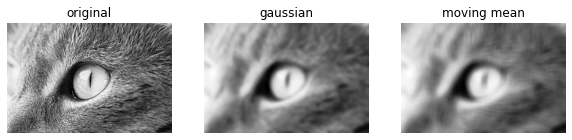

In [13]:
# show results
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap="Greys_r")
plt.title("original")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(g_img, cmap="Greys_r")
plt.title("gaussian")
plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(m_img, cmap="Greys_r")
plt.title("moving mean")
plt.axis("off")

The result image of MMF has moire-like patterns

### Separable Filter
Since convolution is assosiative, when kernel $k$ is separable (e.g., $k = f * g$), the following equation holds:
$$
k * I = (f * g) * I = f * (g * I).
$$
This filter separation reduces the time complexity of convolution $O(HWCM^2)$ to $O(HWCM)$

For instance, Gaussian kernel is separable: 
$$
\begin{bmatrix}
1 & 2 & 1 \\
2 & 4 & 1 \\
1 & 2 & 1
\end{bmatrix} = 
\begin{bmatrix}
1 & 2 & 1
\end{bmatrix} *
\begin{bmatrix}
1 \\ 2 \\ 1
\end{bmatrix}
$$

In [14]:
def conv1d(image, kernel, axis):
    # kernel size should be an odd number
    assert kernel.shape[0] % 2 == 1
    assert axis == 0 or axis == 1
    
    m = kernel.shape[0]
    mdiv2 = m // 2
    h, w, c = image.shape
    
    # extend the image to apply a kernel to the edge
    if axis == 0:
        extended = pad(image, mdiv2, 0)
    else:
        # applying convolution along the y-axis to an image is equivalent
        # to applying convolution along the x-axis to the transposed image
        extended = pad(image, 0, mdiv2)
        extended = np.transpose(extended, [1, 0, 2])
        h, w = w, h
    
    # convolution
    result = np.zeros_like(image)
    if axis == 1:
        result = np.transpose(result, [1, 0, 2])
    
    for i in range(h):
        for j in range(w):
            for k in range(-mdiv2, mdiv2 + 1):
                for ch in range(c):
                    result[i, j, ch] += extended[i - k + mdiv2, j, ch] * kernel[mdiv2 + k]
    
    if axis == 1:
        result = np.transpose(result, [1, 0, 2])
    return result

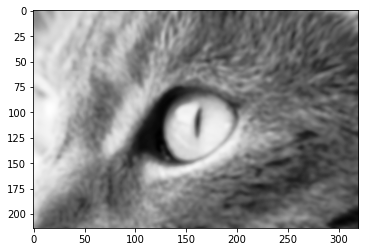

In [15]:
sep_kernel = create_gaussian_kernel(7)[3, :]
sep_kernel = sep_kernel / np.sum(sep_kernel)
filtered = conv1d(img, sep_kernel, axis=0)
filtered = conv1d(filtered, sep_kernel, axis=1)
plt.imshow(filtered, cmap="Greys_r")

## Non-linear Filter

Linear filters has some problems:
* edges get blurred
* impulsive noise aren't removed

There are some non-linear filters that can solve these problems.

### Median Filter
A median filter outputs the median in the kernel
* preserves edges
* removes implusive noise
* also removes thin lines and corners

In [16]:
def median_filter(image, kernel_size):
    assert kernel_size % 2 == 1
    mdiv2 = kernel_size // 2
    # padding
    extended = pad(image, mdiv2, mdiv2)
    
    result = np.empty_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            for c in range(image.shape[2]):
                result[i, j, c] = np.median(extended[i:i + kernel_size, j:j + kernel_size, c])
    return result                

Text(0.5, 1.0, 'median filter')

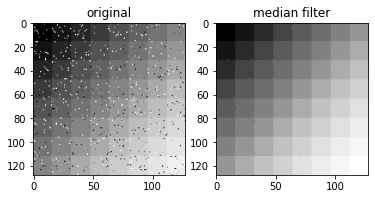

In [17]:
result = median_filter(grid_impulsive, 3)
# show results
plt.subplot(1, 2, 1)
plt.imshow(grid_impulsive, cmap="Greys_r")
plt.title("original")
plt.subplot(1, 2, 2)
plt.imshow(result, cmap="Greys_r")
plt.title("median filter")

Impulsive noise were removed

### Bilateral Filter
Naturally, a filter which can remove noise while preserving edges was looked for.

A Bilateral Filter is defined as follows:
$$
BF[I]_{p} = \frac{1}{W_p} \sum_{q \in K} G_{\sigma_s} \left( \left\| p - q \right\| \right) G_{\sigma_r} \left( \left| I_p - I_q \right| \right) I_q
$$
where $W_p$ is a normalizing factor, $G_\sigma (\cdot)$ is a gaussian with standard deviation of $\sigma$, and $K$ is a kernel.